# Introduction

In this notebook, we analyze single-cell RNA sequencing data from Drosophila (fly) tissue samples. We perform exploratory data analysis, preprocessing, and visualization using PCA and UMAP. We also examine the expression patterns of selected genes over age and sex.


In [ ]:
# Import Necessary Libraries

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scipy.sparse import issparse
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA
import math

# For displaying plots inline in Jupyter Notebook
%matplotlib inline

In [2]:
# Configuration parameters
config = {
    # Device
    "processor": "Other",  # 'Other' or 'M' - M is for Mac M1/M2/M3 processors
    # Data
    "file": "fly_train.h5ad",  # Name of the data file
    "eval_file": "fly_eval.h5ad",  # Name of the data file for final evaluation
    "original_file": "fly_original.h5ad",  # Name of the original data file
    "batch_file": "fly_train_batch.h5ad",  # Name of the batch corrected data file
    "batch_eval_file": "fly_eval_batch.h5ad",  # Name of the batch corrected data file for final evaluation
    "batch_original_file": "fly_original_batch.h5ad",  # Name of the original data file
    "tissue": "head",  # 'head' or 'body'
    "model_type": "cnn",  # 'cnn', 'mlp', 'xgboost', 'random_forest', or 'logistic_regression'
    "encoding_variable": "age",  # Variable to use for encoding: 'sex_age', 'sex', or 'age'
    "batch_correction": False,  # True to perform batch correction, False to skip
    "select_batch_genes": "yes",  # 'yes' to select batch genes, 'no' to skip
}

In [3]:
# Set up directories
Code_dir = os.getcwd()
Data_dir = os.path.join(Code_dir, "Data", "h5ad", config["tissue"])

# Paths to the h5ad files
h5ad_file_path = os.path.join(Data_dir, "uncorrected", config["file"])
h5ad_eval_file_path = os.path.join(Data_dir, "uncorrected", config["eval_file"])
h5ad_file_path_original = os.path.join(Data_dir, "uncorrected", config["original_file"])

# Load the data
adata = sc.read_h5ad(h5ad_file_path)
adata_eval = sc.read_h5ad(h5ad_eval_file_path)
adata_original = sc.read_h5ad(h5ad_file_path_original)

# Filter out mixed
adata = adata[adata.obs["sex"] != "mix"]
adata_eval = adata_eval[adata_eval.obs["sex"] != "mix"]
adata_original = adata_original[adata_original.obs["sex"] != "mix"]

# Load batch corrected data (if necessary)
h5ad_file_path_corrected = os.path.join(
    Data_dir, "batch_corrected", config["batch_file"]
)
adata_corrected = sc.read_h5ad(h5ad_file_path_corrected)

In [5]:
# Print all column names in adata.obs
print("Column names in adata.obs:", adata.obs.columns.tolist())

# Print all unique cell types in the specified column of adata.obs
cell_types = adata.obs["afca_annotation_broad"].unique()
print("Unique cell types:", cell_types)

# Specify the cell type you're interested in
specific_cell_type = "CNS neuron"

# Count the number of cells for the specified cell type
cell_count = (adata.obs["afca_annotation_broad"] == specific_cell_type).sum()
print(f"Total number of cells in {specific_cell_type}: {cell_count}")

# Check sex distribution of sex column in adata.obs
sex_distribution = adata.obs["sex"].value_counts()
print(sex_distribution)

Column names in adata.obs: ['tissue', 'sex', 'age', 'sex_age', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'dataset', 'fca_annotation', 'afca_annotation', 'afca_annotation_broad']
Unique cell types: ['CNS neuron', 'sensory neuron', 'glial cell', 'epithelial cell', 'hemocyte', ..., 'cardial cell', 'somatic precursor cell', 'male reproductive system', 'female germline cell', 'gland']
Length: 16
Categories (16, object): ['CNS neuron', 'cardial cell', 'epithelial cell', 'excretory system', ..., 'muscle cell', 'sensory neuron', 'somatic precursor cell', 'tracheal cell']
Total number of cells in CNS neuron: 159577
sex
female    142976
male      138078
Name: count, dtype: int64


In [10]:
# Convert the data to a DataFrame for easier manipulation
adata.obs = adata.obs.reset_index(drop=False)
df_expression = pd.DataFrame(adata.X.todense(), columns=adata.var_names)
df_expression["sex"] = adata.obs["sex"]
df_expression["age"] = adata.obs["age"]

# Corrected list of top genes
corrected_top_genes = [
    "IncRNA:roX1",
    "IncRNA:roX2",
    "IncRNA:noe",
    "unc-13",
    "IncRA:CR34335",
    "Ank2",
    "Hsp83",
    "Sh",
    "CG4467",
    "pan",
    "CG17684",
    "ninaE",
    "rdgA",
    "nrv3",
    "IncRA:CR43836",
    "CG10077",
    "IncRNA:Hsromega",
    "Syt1",
    "Pdp1",
    "CG41378",
]

# Find columns in the DataFrame that closely match the genes in the corrected_top_genes list
matched_genes_corrected = {}
for gene in corrected_top_genes:
    # Split the gene by ":" and get the last element to find potential matches
    gene_part = gene.split(":")[-1]
    potential_matches = [col for col in df_expression.columns if gene_part in col]
    if potential_matches:
        matched_genes_corrected[gene] = potential_matches[0]
    else:
        matched_genes_corrected[gene] = None

# Filter the dataframe to only include the matched genes and the 'sex' and 'age' columns
valid_matched_genes = [gene for gene in matched_genes_corrected.values() if gene]
filtered_df = df_expression[["sex", "age"] + valid_matched_genes]

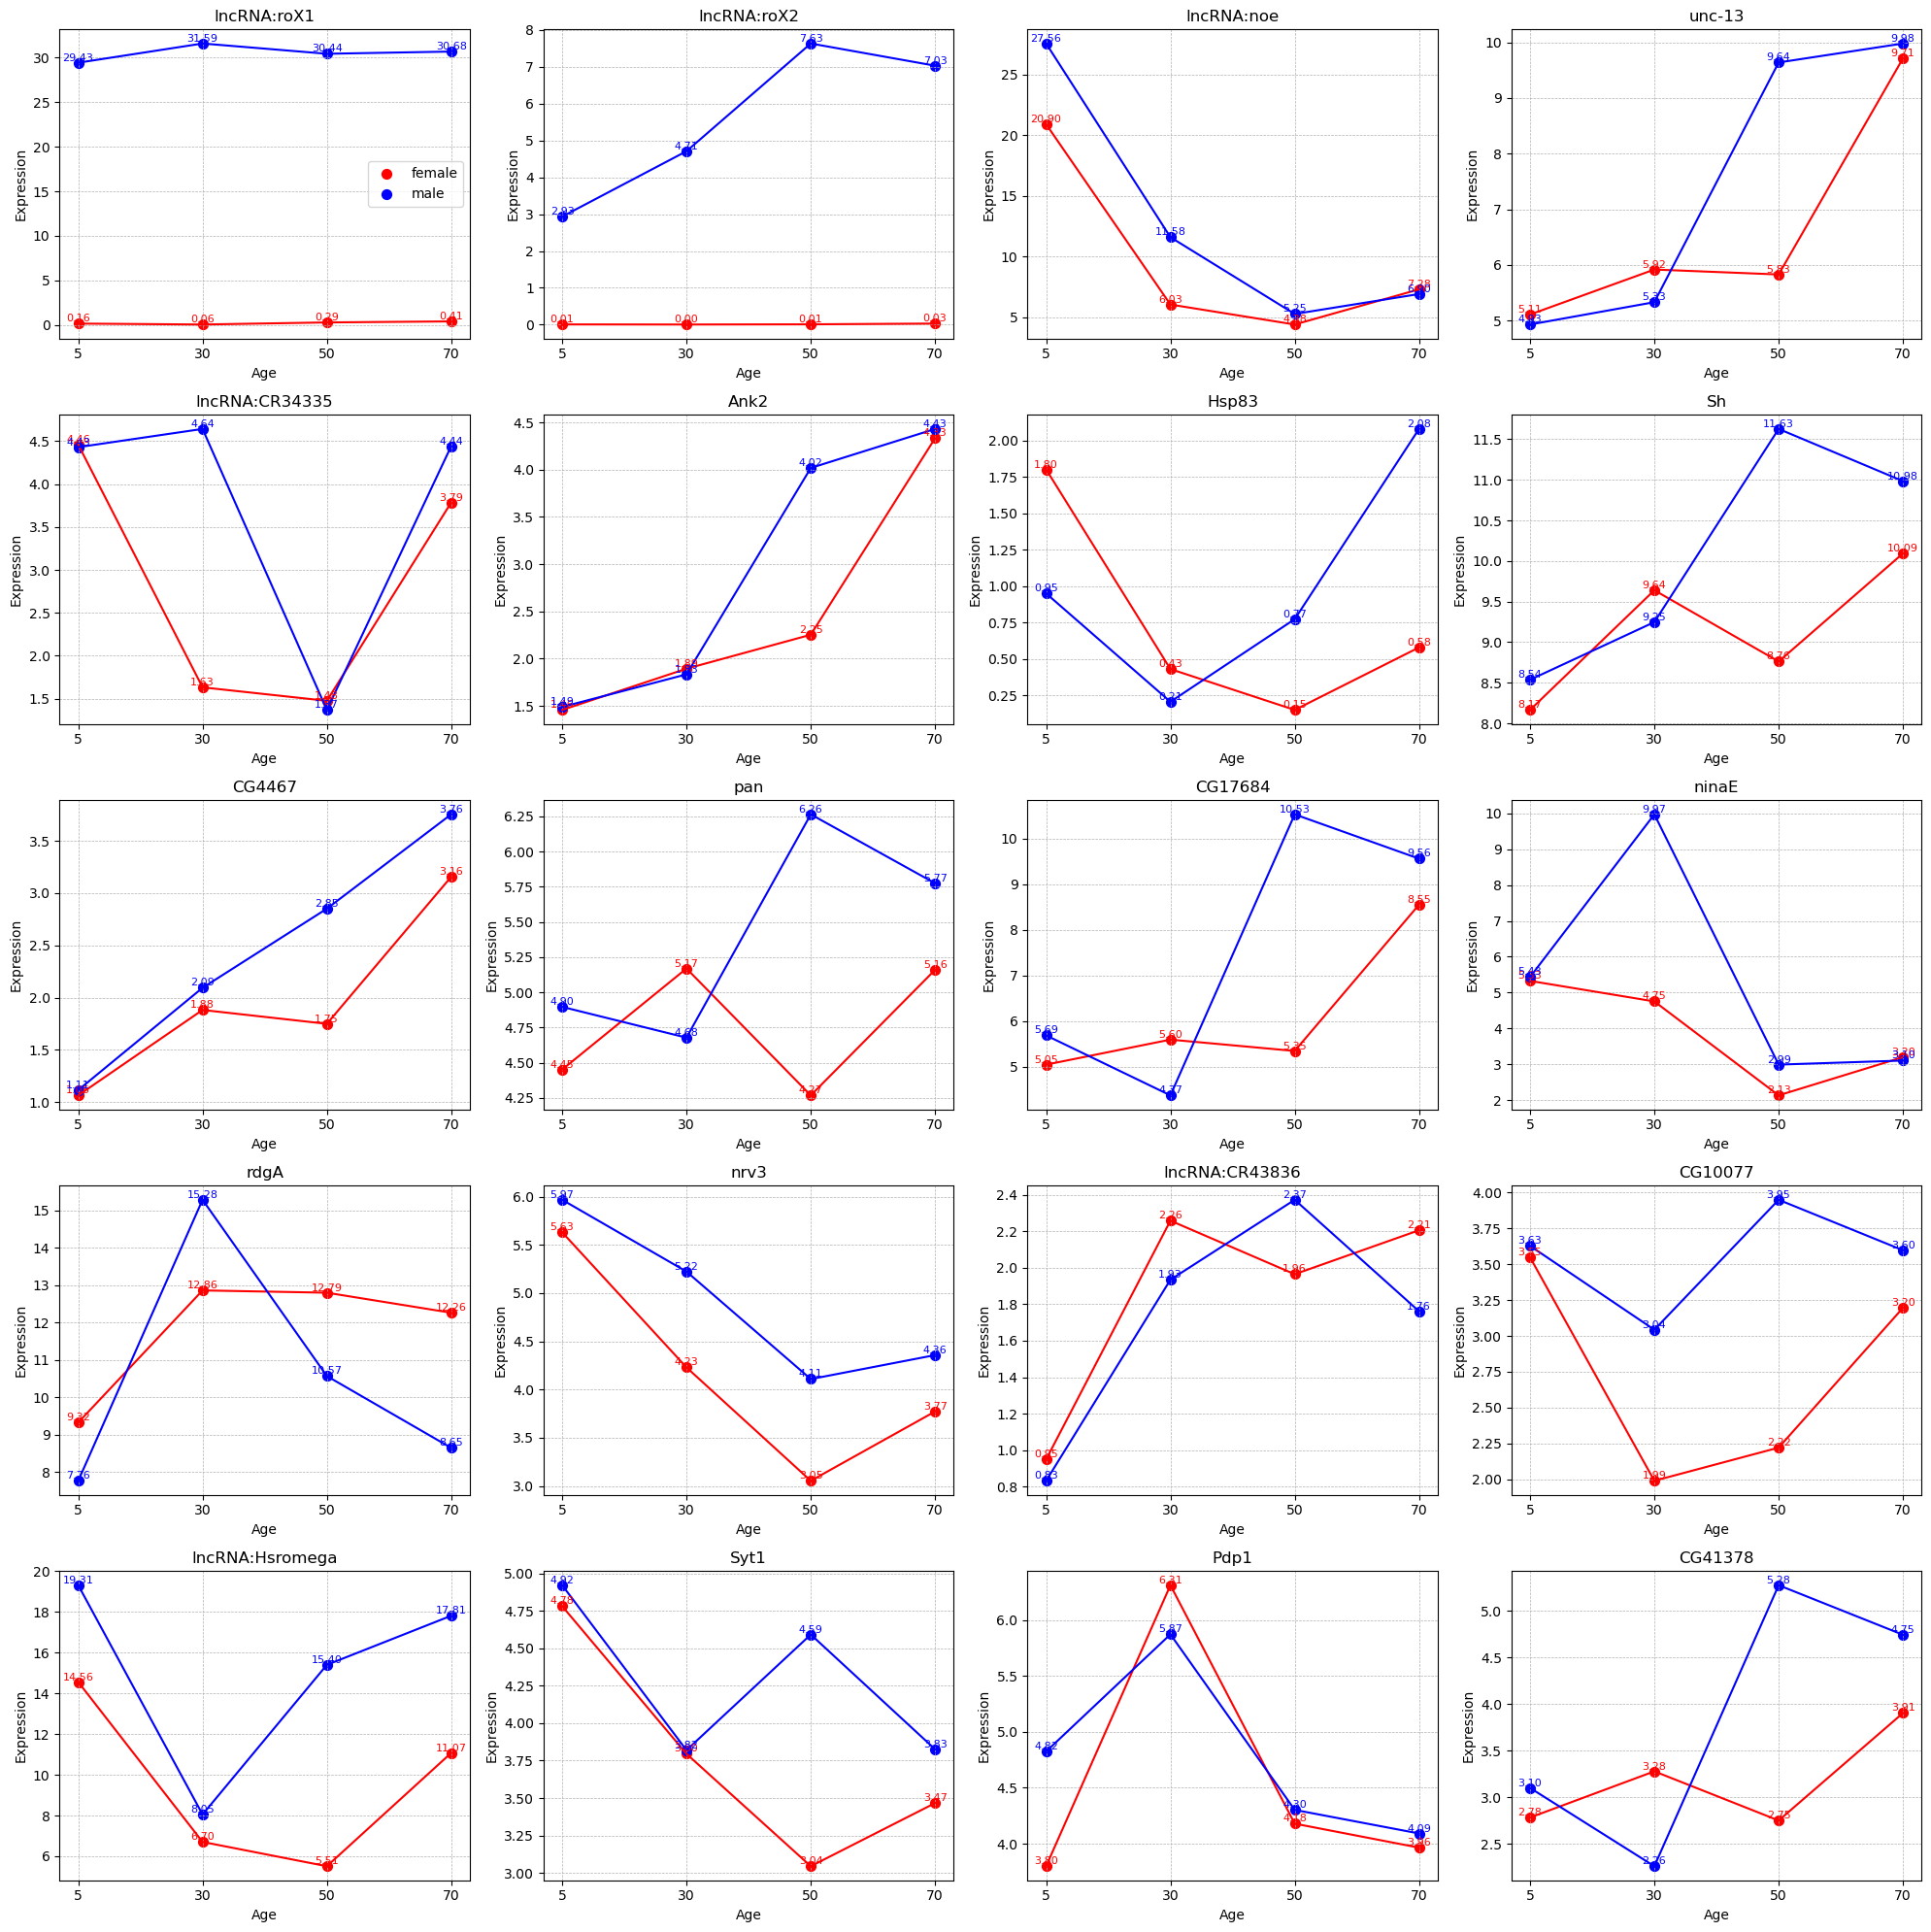

In [29]:
# Plot gene expression over age by sex in a subplot grid
import math

# Number of genes
num_genes = len(valid_matched_genes)

# Define the number of rows and columns for the subplot grid
cols = 4  # Adjust as needed
rows = math.ceil(num_genes / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

# Colors for sexes
colors = {"male": "blue", "female": "red"}

# Loop through each gene and plot
for idx, gene in enumerate(valid_matched_genes):
    ax = axes[idx]
    # Filter the data for the current gene
    gene_df = filtered_df[["sex", "age", gene]]

    # Group by age and sex and compute the mean for the current gene
    grouped_data = gene_df.groupby(["sex", "age"]).mean().reset_index()

    # Plotting with specified colors and annotated data points
    for sex in grouped_data["sex"].unique():
        subset = grouped_data[grouped_data["sex"] == sex]
        ax.scatter(subset["age"], subset[gene], label=sex, color=colors[sex], s=50)
        ax.plot(subset["age"], subset[gene], color=colors[sex], linestyle="-")

        # Annotating the data points with their values
        for x, y in zip(subset["age"], subset[gene]):
            ax.text(
                x,
                y,
                f"{y:.2f}",
                ha="center",
                va="bottom",
                fontsize=8,
                color=colors[sex],
            )

    ax.set_title(f"{gene}")
    ax.set_xlabel("Age")
    ax.set_ylabel("Expression")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Add legend only to the first subplot
    if idx == 0:
        ax.legend()
    else:
        ax.legend().remove()

# Hide any unused subplots
for idx in range(num_genes, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

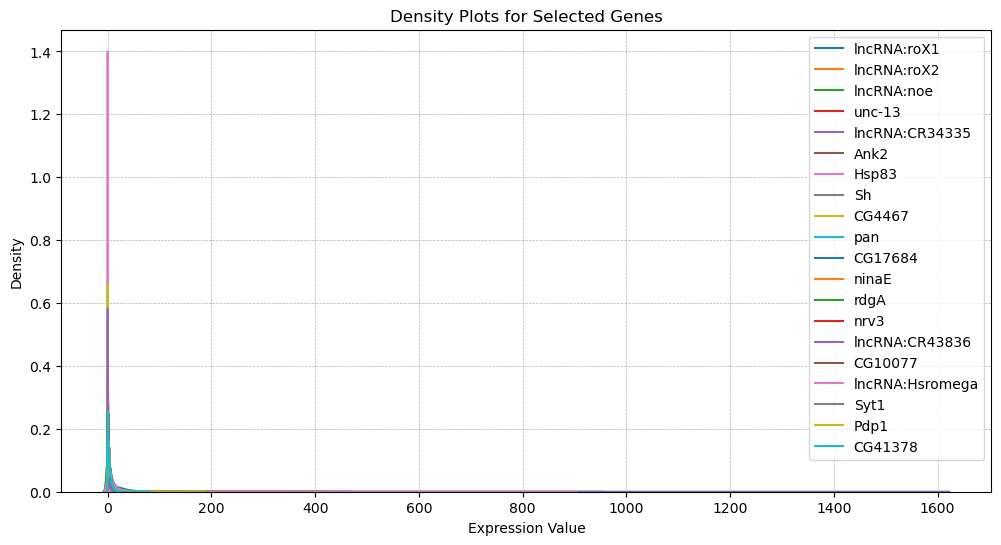

                    count       mean        std  min  25%  50%   75%     max  \
lncRNA:roX1      281054.0  15.016766  22.494200  0.0  0.0  2.0  24.0   459.0   
lncRNA:roX2      281054.0   2.678962   4.858537  0.0  0.0  0.0   4.0    81.0   
lncRNA:noe       281054.0  12.571096  22.044344  0.0  1.0  5.0  14.0   949.0   
unc-13           281054.0   6.929686   7.998526  0.0  1.0  5.0   9.0   333.0   
lncRNA:CR34335   281054.0   3.241687  13.485026  0.0  0.0  1.0   2.0  1619.0   
Ank2             281054.0   2.609587   4.454937  0.0  0.0  1.0   3.0   122.0   
Hsp83            281054.0   0.893682   2.112462  0.0  0.0  0.0   1.0    89.0   
Sh               281054.0   9.578301  12.649039  0.0  0.0  6.0  13.0   171.0   
CG4467           281054.0   2.068962   3.175638  0.0  0.0  1.0   3.0    75.0   
pan              281054.0   5.105403   5.767571  0.0  1.0  3.0   7.0   106.0   
CG17684          281054.0   6.856775   9.028028  0.0  1.0  4.0   9.0   149.0   
ninaE            281054.0   4.600618  16

In [27]:
# Ensure 'filtered_df' contains only the genes and necessary columns
selected_df = filtered_df[valid_matched_genes]

# Plot density plots for the selected genes
plt.figure(figsize=(12, 6))
for gene in valid_matched_genes:
    sns.kdeplot(selected_df[gene], label=gene)

plt.title("Density Plots for Selected Genes")
plt.xlabel("Expression Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# Compute descriptive statistics for the selected genes
desc_stats = selected_df.describe().transpose()
desc_stats["skewness"] = selected_df.skew()
desc_stats["kurtosis"] = selected_df.kurt()
print(desc_stats)

# Display max and min values
max_value = selected_df.max().max()
min_value = selected_df.min().min()
print(f"Max Value in the Dataset: {max_value}")
print(f"Min Value in the Dataset: {min_value}")

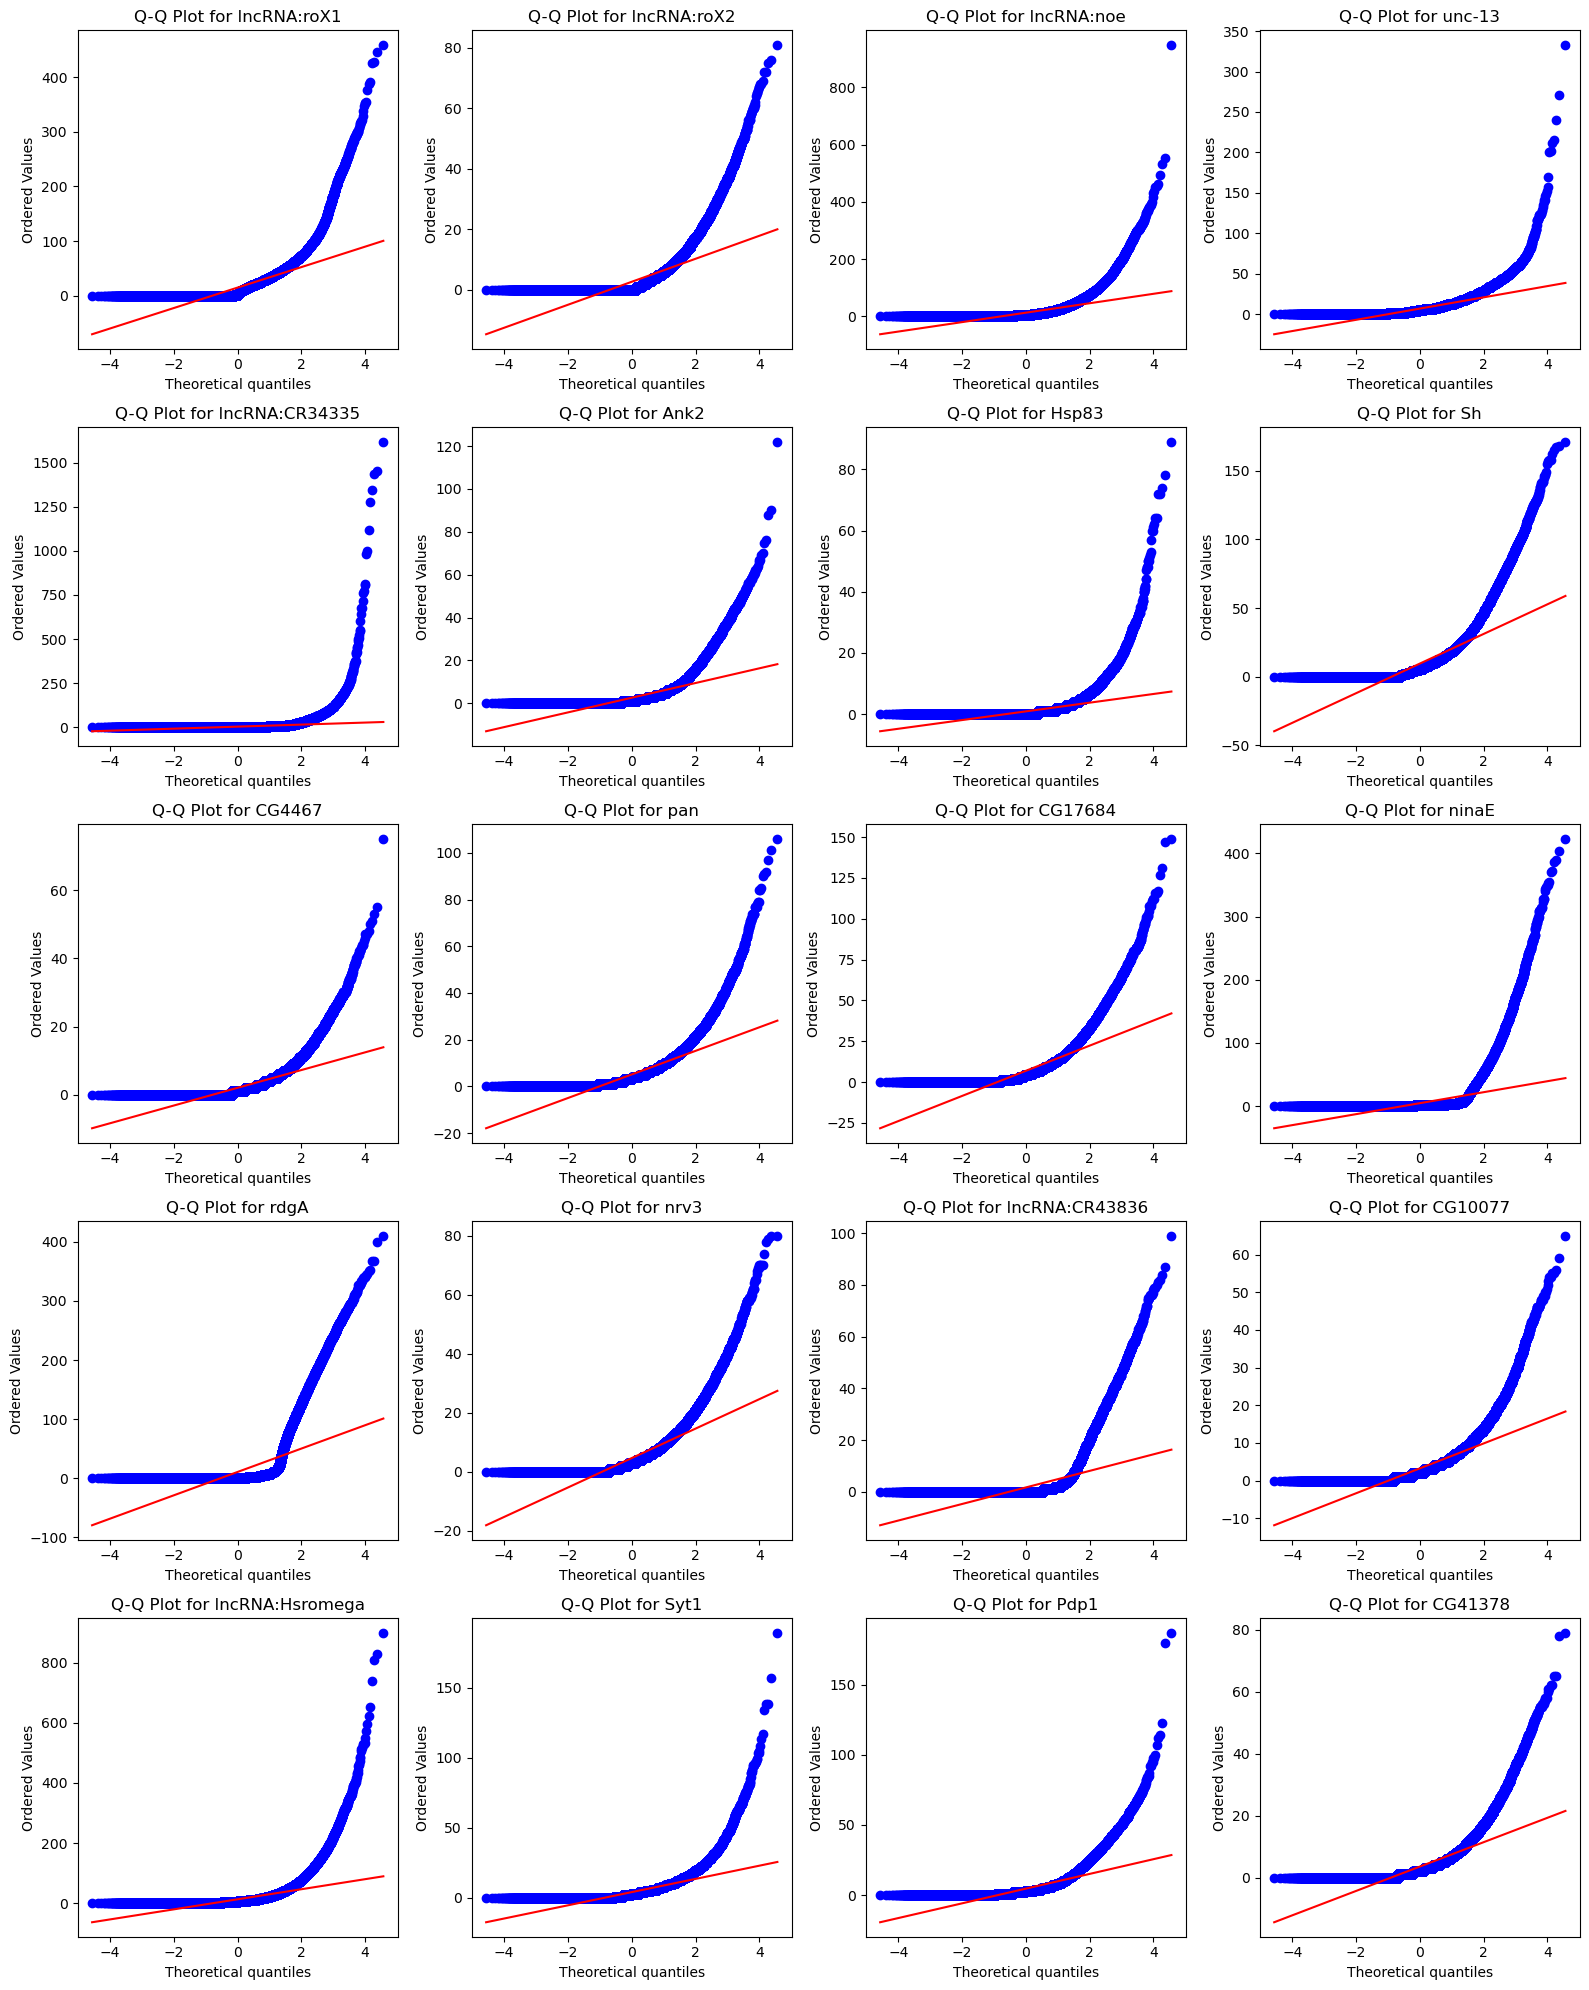

In [ ]:
# Number of genes
num_genes = len(valid_matched_genes)

# Define the number of rows and columns for the subplot grid
cols = 4  # Adjust as needed
rows = math.ceil(num_genes / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()  # Flatten in case of single row

for idx, gene in enumerate(valid_matched_genes):
    ax = axes[idx]
    stats.probplot(selected_df[gene].dropna(), plot=ax)
    ax.set_title(f"Q-Q Plot for {gene}")

# Hide any unused subplots
for idx in range(num_genes, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [ ]:
# Decide which dataset to use based on batch_correction
dataset_to_use = adata_corrected if config["batch_correction"] else adata

# Perform PCA
adata_vis = dataset_to_use.copy()
sc.pp.pca(adata_vis, n_comps=50)

# Plot PCA variance ratio
sc.pl.pca_variance_ratio(adata_vis, n_pcs=50, log=False)

# Calculate total variance explained
total_variance_explained = sum(adata_vis.uns["pca"]["variance_ratio"])
print(
    f"Total variance explained by the first 50 PCs: {total_variance_explained*100:.2f}%"
)

# Compute the neighborhood graph and UMAP
sc.pp.neighbors(adata_vis, n_pcs=50)
sc.tl.umap(adata_vis)

# Plot UMAP colored by age
sc.pl.umap(adata_vis, color="age", title="UMAP Colored by Age")

# Plot UMAP colored by sex
sc.pl.umap(adata_vis, color="sex", title="UMAP Colored by Sex")

In [13]:
X = adata.X.toarray() if issparse(adata.X) else adata.X

# Conduct PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

# Convert the principal components to a DataFrame
df_pca = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
df_pca["sex"] = adata.obs["sex"].values
df_pca["age"] = adata.obs["age"].values

# Plot PCA results colored by biological sex
plt.figure(figsize=(10, 7))
sns.scatterplot(x="PC1", y="PC2", hue="sex", data=df_pca, s=1)
plt.title("PCA Results Colored by Biological Sex")
plt.show()

# Plot PCA results colored by age
plt.figure(figsize=(10, 7))
sns.scatterplot(x="PC1", y="PC2", hue="age", data=df_pca, s=1)
plt.title("PCA Results Colored by Age")
plt.show()

KeyboardInterrupt: 

Conclusion

In this notebook, we successfully performed exploratory data analysis on single-cell RNA sequencing data from Drosophila head tissue. We visualized the data using PCA and UMAP, analyzed the expression patterns of selected genes over age and sex, and observed distinct patterns that could be relevant for further biological interpretation.